<a href="https://colab.research.google.com/github/craobhruadh/MyStatisticalRethinking/blob/main/Statistical_Rethinking_week_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 292 kB 3.9 MB/s 


In [2]:
!pip install jax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random
from jax.scipy.special import expit as logistic

import numpyro 
from numpyro.infer.autoguide import AutoLaplaceApproximation
from numpyro.infer import SVI, Trace_ELBO, MCMC, NUTS
from numpyro.diagnostics import print_summary
import numpyro.distributions as dist
import numpyro.optim as optim

import arviz as az

# Question 1
>The data in data(bangladesh) are 1934 women from the 1989 Bangladesh Fertility Survey. For each woman, we know which district she lived in, her number of living.children, her age.centered, whether she lived in an urban center, and finally whether or not she used contraception (`use.contraception`).

>In this first problem, I only want you to investigate the proportion of women using contraception in each district. Use partial pooling (varying effects). Then compare the varying effect estimates to the raw empirical proportion in each district. Explain the differences between the estimates and the data.

>Note that district number 54 is absent in the data. This causes some problems in indexing the parameters. The simplest fix is just to tell ulam manually how long the vector should be, like this: vector`[61]:a ~ normal(abar,sigma)`. Pay special attention to district number 54’s estimate.


In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/bangladesh.csv', sep=';')

In [5]:
df.head()

,woman,district,use.contraception,living.children,age.centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1934 entries, 0 to 1933
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   woman              1934 non-null   int64  
 1   district           1934 non-null   int64  
 2   use.contraception  1934 non-null   int64  
 3   living.children    1934 non-null   int64  
 4   age.centered       1934 non-null   float64
 5   urban              1934 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 90.8 KB


Alternatively, McElreath uses silly languages like R, reindexing woman should be easy

In [7]:
df.drop('woman',axis=1, inplace=True)

In [8]:
df['woman'] = np.arange(1,  df.shape[0]+1, 1)

In [9]:
def model_q1(district, contraception=None):
    """New goal: leave the single letter variable names with mathematicians and people who got their PhDs 
    before 1980.  Can we write this to be more pythonic?
    
    ...even if this is numpyro and passing in variables into functions without declaring it an explicit
    input is okay in this framework
    """

    a_bar = numpyro.sample("a_bar", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    output = numpyro.sample("output", dist.Normal(a_bar, sigma), sample_shape=district.shape)
    logits = output[district]
    numpyro.sample("contraception_hat", dist.Bernoulli(logits=logits), obs=contraception)

kernel = NUTS(model_q1)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='sequential')
mcmc.run(random.PRNGKey(2), df['district'].values, df['use.contraception'].values)

sample: 100%|██████████| 2000/2000 [00:24<00:00, 82.38it/s, 63 steps of size 1.09e-01. acc. prob=0.90]


In [10]:
# mcmc.print_summary()


In [11]:
samples_q1 = az.from_numpyro(mcmc)
az.summary(samples_q1, var_names=['a_bar', 'sigma'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.553,0.094,-0.705,-0.406,0.014,0.010,47.0,230.0,1.08
sigma,0.554,0.116,0.336,0.716,0.026,0.019,20.0,62.0,1.14


<BarContainer object of 60 artists>

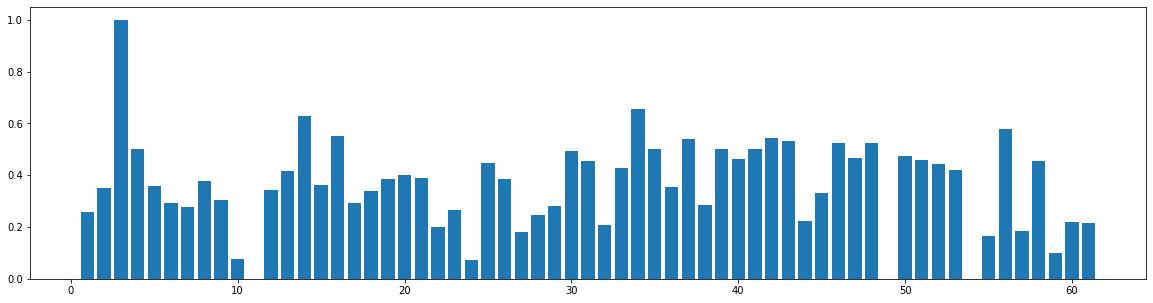

In [12]:
pct_using_contraception = df.groupby('district')['use.contraception'].sum()/df.groupby('district')['woman'].nunique()

plt.figure(figsize=(20,5))
plt.bar(pct_using_contraception.keys(), pct_using_contraception.values)

In [13]:
pct_using_contraception.keys()

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 55, 56, 57, 58, 59, 60, 61],
           dtype='int64', name='district')

In [16]:
# def model_q3(district, urban, contraception=None):
#     """Adding urban living as a variable for contraception
#     """

#     a_bar = numpyro.sample("a_bar", dist.Normal(0, 1))
#     sigma = numpyro.sample("sigma", dist.Exponential(1))
#     output = numpyro.sample("output", dist.Normal(a_bar, sigma), sample_shape=district.shape)
#     logits = output[district]
#     numpyro.sample("contraception_hat", dist.Bernoulli(logits=logits), obs=contraception)

# kernel = NUTS(model_q1)
# mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='sequential')
# mcmc.run(random.PRNGKey(2), df['district'].values, df['use.contraception'].values)

In [30]:
# Is there a way to pass in constants to a numpyro function?  This is not a
# good python practice
n_district = df['district'].nunique()
n_urban =  df['urban'].nunique()

def model_q3(district, urban, contraception=None):
    """Add a new variable, urban to this!
    """

    a_bar = numpyro.sample("a_bar", dist.Normal(0, 1))
    b_bar = numpyro.sample("b_bar", dist.Normal(0,1))
    sigma_ab = numpyro.sample("sigma_ab", dist.Exponential(1), sample_shape=(2,))
    rho = numpyro.sample('rho', dist.LKJ(2,2))

    mu = jnp.stack([a_bar, b_bar])
    covariance = jnp.outer(sigma_ab, sigma_ab)*rho
    # n_district, n_urban = len(jnp.unique(district)), len(jnp.unique(urban))
    priors = numpyro.sample(
        "priors", 
        dist.MultivariateNormal(
            mu, covariance
        ),
        sample_shape=(n_district, n_urban)
    )


    a_district, b_district = priors[:,:,0], priors[:,:,1]
    theta = a_district[district, urban] + b_district[district, urban]*urban
    contraception_hat = numpyro.sample(
        'contraception_hat',
         dist.Bernoulli(logits=theta), 
         obs=contraception
    )


kernel = NUTS(model_q3)
mcmc = MCMC(
    kernel, 
    num_warmup=1000, 
    num_samples=1000, 
    num_chains=4, 
    chain_method='sequential'
)
mcmc.run(
    random.PRNGKey(0), 
    df['district'].values, 
    df['urban'].values, 
    df['use.contraception'].values
)

sample: 100%|██████████| 2000/2000 [02:26<00:00, 13.67it/s, 1023 steps of size 6.29e-04. acc. prob=0.85]


In [31]:
samples_q3 = az.from_numpyro(mcmc)
az.summary(samples_q3, var_names=['a_bar', 'b_bar', 'sigma_ab'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.699,0.079,-0.820,-0.567,0.016,0.012,25.0,119.0,1.15
b_bar,0.732,0.120,0.532,0.915,0.037,0.027,11.0,54.0,1.29
sigma_ab[0],0.593,0.092,0.453,0.743,0.030,0.022,10.0,52.0,1.39
sigma_ab[1],0.339,0.321,0.003,0.859,0.148,0.112,5.0,11.0,2.28


In [33]:
# Is there a way to pass in constants to a numpyro function?  This is not a
# good python practice
n_district = df['district'].nunique()
n_urban =  df['urban'].nunique()

def model_q3_v2(district, urban, contraception=None):
    """Add a new variable, urban to this!
    """

    a_bar = numpyro.sample("a_bar", dist.Normal(0, 1))
    b_bar = numpyro.sample("b_bar", dist.Normal(0,1))
    sigma_ab = numpyro.sample("sigma_ab", dist.Exponential(1), sample_shape=(2,))
    rho = numpyro.sample('rho', dist.LKJ(2,2))

    mu = jnp.stack([a_bar, b_bar])
    covariance = jnp.outer(sigma_ab, sigma_ab)*rho
    # n_district, n_urban = len(jnp.unique(district)), len(jnp.unique(urban))
    priors = numpyro.sample(
        "priors", 
        dist.MultivariateNormal(
            mu, covariance
        ),
        sample_shape=(n_district,)
    )


    theta = priors[district, urban] 
    contraception_hat = numpyro.sample(
        'contraception_hat',
         dist.Bernoulli(logits=theta), 
         obs=contraception
    )


kernel = NUTS(model_q3_v2)
mcmc = MCMC(
    kernel, 
    num_warmup=1000, 
    num_samples=1000, 
    num_chains=4, 
    chain_method='sequential'
)
mcmc.run(
    random.PRNGKey(0), 
    df['district'].values, 
    df['urban'].values, 
    df['use.contraception'].values
)

sample: 100%|██████████| 2000/2000 [03:07<00:00, 10.69it/s, 1023 steps of size 9.81e-04. acc. prob=0.85]


In [34]:
samples_q3_v2 = az.from_numpyro(mcmc)
az.summary(samples_q3_v2, var_names=['a_bar', 'b_bar', 'sigma_ab'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.693,0.111,-0.864,-0.508,0.008,0.006,200.0,445.0,1.03
b_bar,0.042,0.147,-0.192,0.255,0.024,0.017,40.0,79.0,1.08
sigma_ab[0],0.619,0.105,0.446,0.776,0.012,0.008,74.0,189.0,1.05
sigma_ab[1],0.558,0.167,0.289,0.805,0.027,0.020,37.0,97.0,1.07
